In [2]:
import numpy as np

data = np.load('data/AA00400AA.npy', allow_pickle=True)

In [4]:
data.shape

(17751,)

In [8]:
data[1].shape

(157, 2)

In [12]:
data[1].min(axis=0)

array([9.9999998e-03, 1.3154976e+01], dtype=float32)

In [13]:
data[1].max(axis=0)

array([  1.57  , 103.8309], dtype=float32)

In [14]:
import matplotlib.pyplot as plt

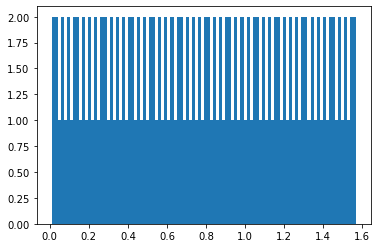

In [16]:
plt.hist(data[1][:, 0], bins=100)
plt.show()

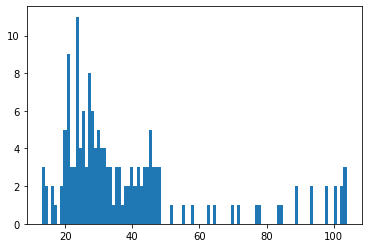

In [17]:
plt.hist(data[1][:, 1], bins=100)
plt.show()

In [31]:
def encode_event_average(event):
    return event.mean(axis=0)

def build_data(data_path, label):
    raw_data = np.load(data_path, allow_pickle=True)
    data = []
    for event in raw_data:
        data.append(encode_event_average(event))
    return np.hstack([np.repeat(label, len(data)).reshape(-1, 1), np.array(data)])

In [34]:
data_paths = ['data/AA00400AA.npy', 'data/AA00500AA.npy',
              'data/AA000040000AA.npy', 'data/AA000050000AA.npy',
              'data/AA66266AA.npy', 'data/AA66466AA.npy',
              'data/AA66566AA.npy', 'data/AA662266AA.npy']

data = []
for i, data_path in enumerate(data_paths):
    data.append(build_data(data_path, i))

data = np.vstack(data)


In [36]:
data

array([[ 0.        ,  4.94999933, 35.9413147 ],
       [ 0.        ,  0.79000002, 38.64290237],
       [ 0.        ,  9.80500031, 34.10925293],
       ...,
       [ 7.        ,  0.80000007, 47.5545311 ],
       [ 7.        ,  0.285     , 54.18340683],
       [ 7.        ,  1.68500006, 31.66427422]])

In [43]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True)

In [45]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_data[:, 1:], train_data[:, 0])

/Users/mismayil/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()